## Lab 2

In [ ]:
!pip install tensorflow -q

In [ ]:
!pip install matplotlib -q

In [ ]:
!pip install TensorRT

In [ ]:
!pip install torch

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
#if not os.path.exists('sonnets.txt'):
#    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

#with open('sonnets.txt', 'r') as iofile:
#    text = iofile.readlines()

#TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

#text = ''.join(text).lower()# Your great code here

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [61]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
#text = ''.join(text).lower()
#text = [x.replace('\t\t', '') for x in text]

In [62]:
chars = sorted(set(text))  # Get a sorted list of all unique characters
char_to_index = {ch: i for i, ch in enumerate(chars)}  # Character to index mapping
index_to_char = {i: ch for i, ch in enumerate(chars)}  # Index to character mapping


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.
out = ''.join(text).lower()


# Your great code here


In [ ]:
out

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(out))

In [ ]:
tokens

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
# Create a sorted list of unique characters
# Dictionary mapping index to character
idx_to_token = {index: char for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
# Dictionary mapping character to index
token_to_idx = {char: index for index, char in enumerate(tokens)}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Your code here
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

In [ ]:
#sentences
[[item for item in sublist if item] for sublist in sentences]

In [64]:
# Assuming text is already loaded and preprocessed as in your snippet

# Constants
MAXLEN = 40  # Length of extracted character sequences
STEP = 3  # Step size for moving the reading window



# Cut the text in semi-redundant sequences of MAXLEN characters
sentences = []
next_chars = []
for i in range(0, len(text) - MAXLEN, STEP):
    sentences.append(text[i: i + MAXLEN])
    next_chars.append(text[i + MAXLEN])
sentences = [[item for item in sublist if item] for sublist in sentences]
# One-hot encoding
x = np.zeros((len(sentences), MAXLEN, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        if char in char_to_index:  # Check if the char is in the dictionary
            x[i, t, char_to_index[char]] = 1
        else:
            print(f"Missing character in dictionary: {char}")  # This will help identify any missing characters
    next_char = next_chars[i]
    if next_char in char_to_index:
        y[i, char_to_index[next_char]] = 1
    else:
        print(f"Missing next character in dictionary: {next_char}")
# Build the model: a single LSTM
model = Sequential([
    SimpleRNN(128, input_shape=(MAXLEN, len(chars))),
    Dense(len(chars), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

# Helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Function invoked at end of each epoch to print generated text
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(text) - MAXLEN - 1)
    generated = ''
    sentence = text[start_index: start_index + MAXLEN]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, MAXLEN, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = True

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature=1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


/home/gitpod/.pyenv/versions/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:

history = model.fit(x, y, batch_size=128, epochs=10)

Epoch 1/10


2024-05-11 17:26:08.007584: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499704000 exceeds 10% of free system memory.


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 4.7089
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - loss: 4.7901
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - loss: 4.7529
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 4.6432
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 4.7693
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 4.6782
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 4.6242
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - loss: 4.5931
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - loss: 4.5394
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - loss: 4.5579


Plot the loss function (axis X: number of epochs, axis Y: loss function).

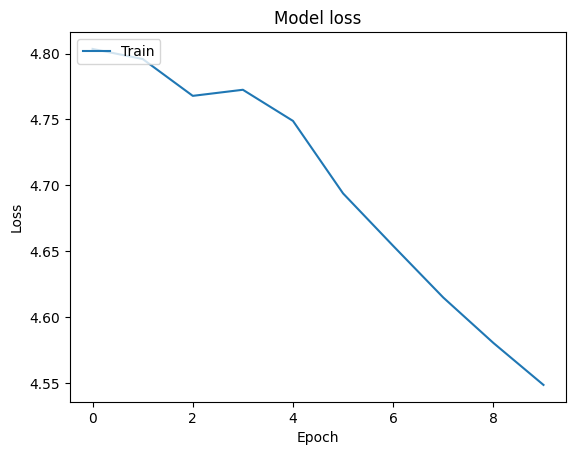

In [69]:
import sys
# Your plot code here
#history = model.fit(x, y, batch_size=128, epochs=30, callbacks=[print_callback])

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


In [70]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_sample(char_rnn, seed_phrase=' Правил', max_length=100, temperature=1.0, token_to_idx=None, idx_to_token=None):
    '''
    Generates text given a phrase of length at least SEQ_LENGTH.

    :param char_rnn: The trained character RNN model.
    :param seed_phrase: The initial string to start text generation.
    :param max_length: The maximum length of the generated text.
    :param temperature: The temperature for sampling (controls randomness).
    :param token_to_idx: Dictionary mapping characters to their indices.
    :param idx_to_token: Dictionary mapping indices back to characters.
    '''
    # Initialize the sequence of indices with the seed phrase
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Initial hidden state
    hid_state = char_rnn.initial_state(batch_size=1)

    # Feed the seed phrase to the RNN to build up the hidden state
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, i:i+1], hid_state)

    # Generate new characters
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1:], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0, -1]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix_tensor = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix_tensor], dim=1)

    # Convert indices to characters
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

# Example usage (assuming you have a trained model 'char_rnn', and dictionaries 'token_to_idx', 'idx_to_token'):
# print(generate_sample(char_rnn, seed_phrase=" Hello", max_length=100, temperature=0.5, token_to_idx=token_to_idx, idx_to_token=idx_to_token))


ModuleNotFoundError: No module named 'torch'

In [ ]:
def generate_text(model, char_to_index, indices_char, seed_phrase="Hello", length=500, temperature=0.2):
    """
    Generate text using a trained RNN model.

    :param model: Trained Keras model
    :param char_to_index: Dictionary mapping characters to their indices
    :param indices_char: Dictionary mapping indices to their characters
    :param seed_phrase: Initial phrase to start text generation
    :param length: Total length of the text to generate
    :param temperature: Sampling temperature
    """
    seed_phrase = seed_phrase.lower()
    seed_length = len(seed_phrase)
    if seed_length < MAXLEN:
        # Pad the seed_phrase if it's too short
        seed_phrase = seed_phrase.rjust(MAXLEN)
    elif seed_length > MAXLEN:
        # Truncate the seed_phrase if it's too long
        seed_phrase = seed_phrase[:MAXLEN]
    # Prepare the seed phrase as the initial input to the model
    generated = seed_phrase.lower()
    sentence = seed_phrase.lower()

    # Generate the text
    for i in range(length - len(seed_phrase)):
        # Prepare the input tensor
        x_pred = np.zeros((1, len(sentence), len(char_to_index)), dtype=np.bool_)
        for t, char in enumerate(sentence):
            x_pred[0, t, char_to_index[char]] = True

        # Make a prediction (output is logits, not probabilities)
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        # Append the new character and shift the sentence to include it
        generated += next_char
        sentence = sentence[1:] + next_char

        # Reset the sentence if it gets too long to process (optional)
        if len(sentence) > MAXLEN:
            sentence = sentence[-MAXLEN:]

    return generated

def sample(preds, temperature=1.0):
    """ Helper function to sample an index from a probability array """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature  # avoid log(0) error
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
# Example usage:
# Assume `model`, `char_to_index`, and `indices_char` are already defined
generated_text = generate_text(model, char_indices, indices_char, seed_phrase="Hello dier frend", length=500, temperature=0.2)
print(generated_text)

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
from tensorflow.keras.layers import LSTM
# Your beautiful code here
# Build the model: a single LSTM
modelLSTM = Sequential([
    LSTM(128, input_shape=(MAXLEN, len(chars))),
    Dense(len(chars), activation='softmax'),
])

modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
history = modelLSTM.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=[print_callback])

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
phrase = 'Which on thy soft cheek for complexion dwells'
for temp in [0.1, 0.2, 0.5, 1.0, 1.2]:
  print(f"Temperature: {temp}")
  print('vanilla RNN: ',generate_text(model, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))
  print('LSTM: ', generate_text(modelLSTM, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

In [ ]:
model.save('Shakespeare_sonnets_vanilla_RNN.h5')
modelLSTM.save('Shakespeare_sonnets_LSTM.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load models
loaded_vanilla_rnn = load_model('Shakespeare_sonnets_vanilla_RNN.h5')
loaded_lstm = load_model('Shakespeare_sonnets_LSTM.h5')

In [ ]:
phrase1 = 'The sun shine'
print('vanilla RNN: ',generate_text(loaded_vanilla_rnn, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))
print('LSTM: ', generate_text(loaded_lstm, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)